<h1><font size="6">Cataract Classification</font></h1>

In this notebook, uses two retina datasets to challenge the cataract classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Build the model(1)](#build1)
* [Build the model(2)](#build2)

## Import libraries <a name="import"> </a>

In [1]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

## Set configurations and read metadata <a name="set"> </a>

In [3]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = '../input/cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx')

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [5]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
100,../input/cataractdataset/dataset/2_cataract/ca...,1
101,../input/cataractdataset/dataset/2_cataract/ca...,1
102,../input/cataractdataset/dataset/2_cataract/ca...,1
103,../input/cataractdataset/dataset/2_cataract/ca...,1
104,../input/cataractdataset/dataset/2_cataract/ca...,1
...,...,...
495,../input/cataractdataset/dataset/1_normal/NL_2...,0
496,../input/cataractdataset/dataset/1_normal/NL_1...,0
497,../input/cataractdataset/dataset/1_normal/NL_1...,0
498,../input/cataractdataset/dataset/1_normal/NL_1...,0


In [6]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


## Process Ocular disease recognition dataset <a name="process2"> </a>

In [7]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [8]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [9]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [10]:
le_df.head()

,cataract,paths
0,1,../input/ocular-disease-recognition-odir5k/ODI...
1,0,../input/ocular-disease-recognition-odir5k/ODI...
2,0,../input/ocular-disease-recognition-odir5k/ODI...
3,0,../input/ocular-disease-recognition-odir5k/ODI...
4,0,../input/ocular-disease-recognition-odir5k/ODI...


In [11]:
re_df.head()

,cataract,paths
0,0,../input/ocular-disease-recognition-odir5k/ODI...
1,0,../input/ocular-disease-recognition-odir5k/ODI...
2,0,../input/ocular-disease-recognition-odir5k/ODI...
3,0,../input/ocular-disease-recognition-odir5k/ODI...
4,0,../input/ocular-disease-recognition-odir5k/ODI...


In [12]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


There is a large bias in the dataset. So make it even.

In [13]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [14]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,../input/ocular-disease-recognition-odir5k/ODI...
81,1,../input/ocular-disease-recognition-odir5k/ODI...
103,1,../input/ocular-disease-recognition-odir5k/ODI...
119,1,../input/ocular-disease-recognition-odir5k/ODI...
253,1,../input/ocular-disease-recognition-odir5k/ODI...


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [15]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,../input/cataractdataset/dataset/2_cataract/ca...,1
1,../input/cataractdataset/dataset/2_cataract/ca...,1
2,../input/cataractdataset/dataset/2_cataract/ca...,1
3,../input/cataractdataset/dataset/2_cataract/ca...,1
4,../input/cataractdataset/dataset/2_cataract/ca...,1
...,...,...
1021,../input/ocular-disease-recognition-odir5k/ODI...,0
1022,../input/ocular-disease-recognition-odir5k/ODI...,0
1023,../input/ocular-disease-recognition-odir5k/ODI...,0
1024,../input/ocular-disease-recognition-odir5k/ODI...,0


In [16]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [17]:
from skimage import io

def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = io.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [00:21<00:00,  9.41it/s]


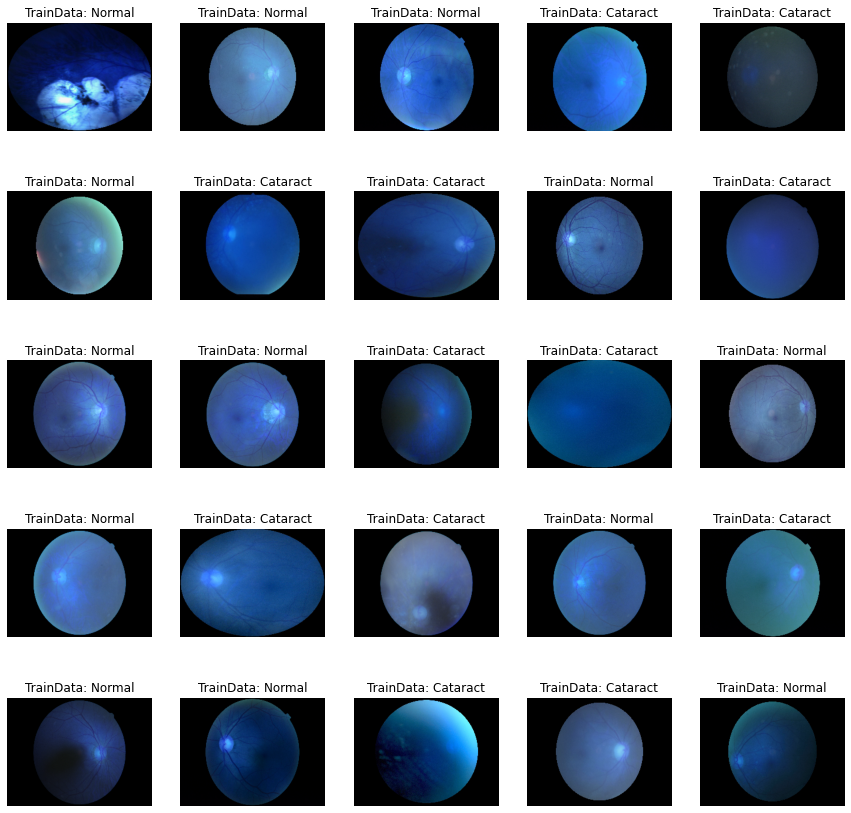

In [18]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

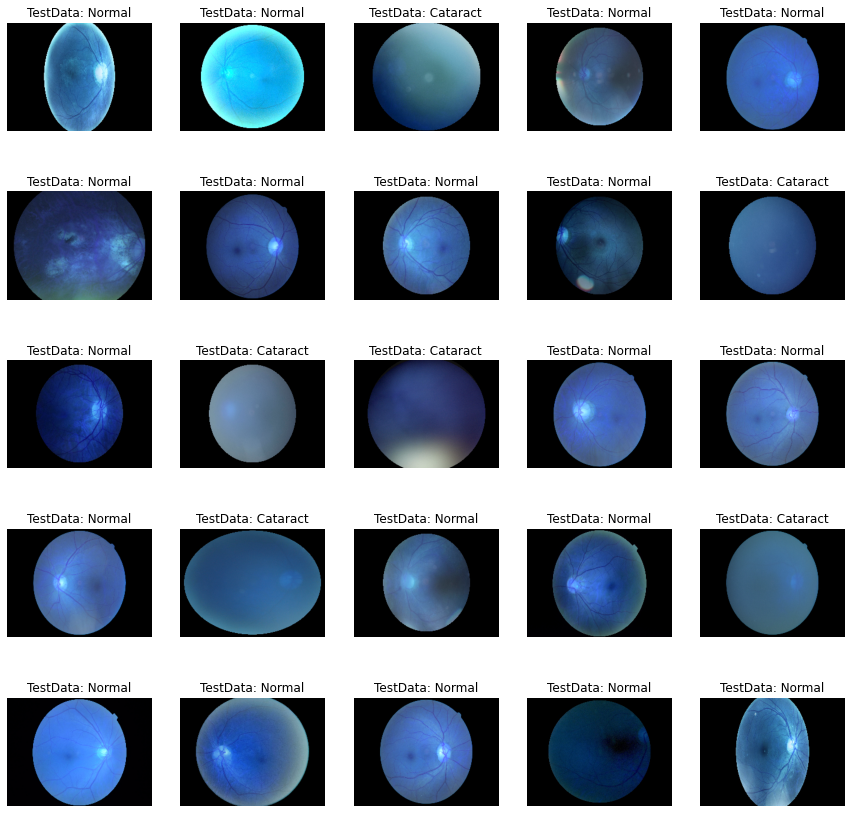

In [19]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

## Build the model(1) <a name="build1"> </a>

In [20]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})


In [21]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model1 = Sequential()
model1.add(Conv2D(16, kernel_size=3, padding='same', input_shape=input_shape, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(3))
model1.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(3))
model1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(3))
model1.add(Flatten())
model1.add(Dense(1024))
model1.add(Dropout(0.5))
model1.add(Dense(512))
model1.add(Dropout(0.7))
model1.add(Dense(128))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 85, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 85, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 28, 64)        1

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [22]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
22/21 [==============================] - 7s 299ms/step - loss: 25.8224 - accuracy: 0.6399 - val_loss: 0.7001 - val_accuracy: 0.7724
Epoch 2/100
22/21 [==============================] - 7s 314ms/step - loss: 33.1120 - accuracy: 0.6772 - val_loss: 1.6177 - val_accuracy: 0.7154
Epoch 3/100
22/21 [==============================] - 6s 291ms/step - loss: 29.5979 - accuracy: 0.6614 - val_loss: 0.9323 - val_accuracy: 0.7480
Epoch 4/100
22/21 [==============================] - 7s 297ms/step - loss: 22.9449 - accuracy: 0.6643 - val_loss: 3.3565 - val_accuracy: 0.4146
Epoch 5/100
22/21 [==============================] - 6s 281ms/step - loss: 24.6465 - accuracy: 0.6671 - val_loss: 3.5338 - val_accuracy: 0.6748
Epoch 6/100
22/21 [==============================] - 7s 324ms/step - loss: 16.6790 - accuracy: 0.6887 - val_loss: 6.5451 - val_accuracy: 0.6829
Epoch 7/100
22/21 [==============================] - 6s 291ms/step - loss: 17.2232 - accuracy: 0.6758 - val_loss: 1.2838 - val_accuracy:

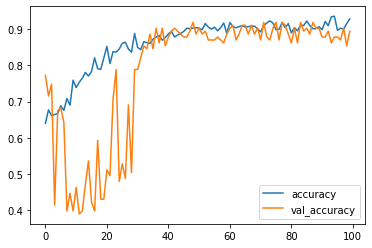

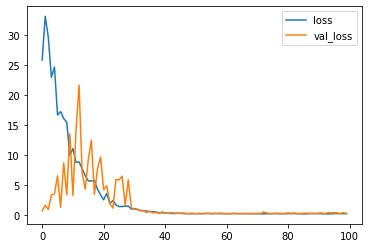

In [23]:
history = model1.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [29]:
model1.evaluate(test_imgs, test_df)

22/22 [==============================] - 0s 11ms/step - loss: 0.1547 - accuracy: 0.9383


[0.1547486037015915, 0.9383070468902588]

### Building on a pre-trained model(Transfer Learning) <a name="build2"> </a>

In [25]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [30]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
22/21 [==============================] - 8s 371ms/step - loss: 0.5015 - accuracy: 0.8020 - val_loss: 0.5031 - val_accuracy: 0.8537
Epoch 2/100
22/21 [==============================] - 9s 406ms/step - loss: 0.4869 - accuracy: 0.8293 - val_loss: 0.4980 - val_accuracy: 0.8537
Epoch 3/100
22/21 [==============================] - 8s 374ms/step - loss: 0.4663 - accuracy: 0.8436 - val_loss: 0.4963 - val_accuracy: 0.8293
Epoch 4/100
22/21 [==============================] - 8s 375ms/step - loss: 0.4394 - accuracy: 0.8479 - val_loss: 0.4930 - val_accuracy: 0.8049
Epoch 5/100
22/21 [==============================] - 8s 367ms/step - loss: 0.4377 - accuracy: 0.8451 - val_loss: 0.4817 - val_accuracy: 0.8211
Epoch 6/100
22/21 [==============================] - 8s 372ms/step - loss: 0.4196 - accuracy: 0.8623 - val_loss: 0.4627 - val_accuracy: 0.8455
Epoch 7/100
22/21 [==============================] - 8s 377ms/step - loss: 0.4035 - accuracy: 0.8752 - val_loss: 0.4430 - val_accuracy: 0.8618

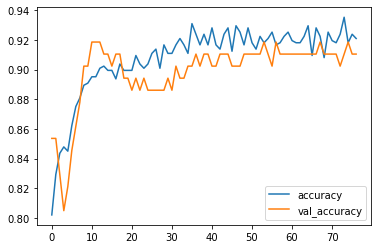

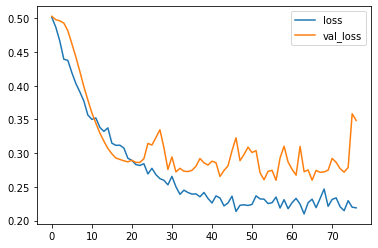

In [31]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=100,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [33]:
model.evaluate(test_imgs, test_df) 

7/7 [==============================] - 0s 32ms/step - loss: 0.2563 - accuracy: 0.9078


[0.25626567006111145, 0.9077669978141785]